In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
import shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

Disease
N                                 35
Asthma                            17
heart failure                     15
asthma                            15
COPD                               8
pneumonia                          5
Lung Fibrosis                      4
Heart Failure                      3
BRON                               3
Heart Failure + COPD               2
Plueral Effusion                   2
Heart Failure + Lung Fibrosis      1
Asthma and lung fibrosis           1
copd                               1
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Asthma'),
  Text(1, 0, 'Heart Failure + Lung Fibrosis '),
  Text(2, 0, 'Heart Failure + COPD'),
  Text(3, 0, 'Plueral Effusion'),
  Text(4, 0, 'Heart Failure'),
  Text(5, 0, 'heart failure'),
  Text(6, 0, 'COPD'),
  Text(7, 0, 'pneumonia'),
  Text(8, 0, 'Asthma and lung fibrosis'),
  Text(9, 0, 'BRON'),
  Text(10, 0, 'Lung Fibrosis'),
  Text(11, 0, 'copd'),
  Text(12, 0, 'asthma'),
  Text(13, 0, 'N')])

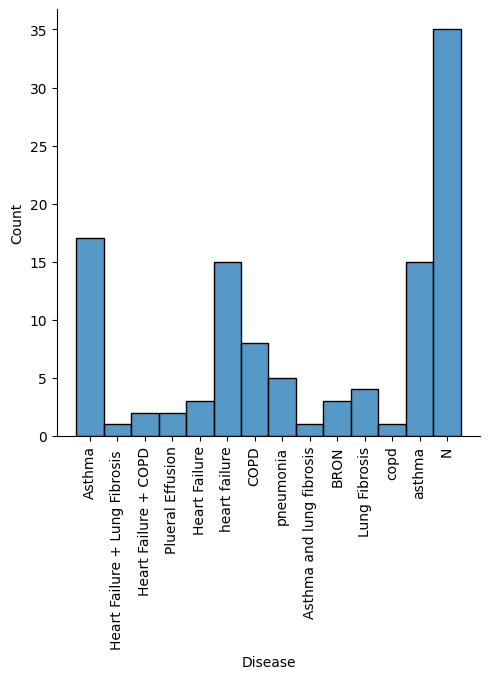

In [63]:
diagnosis_data = pd.read_excel('../input/lung-dataset/Data annotation.xlsx',usecols='B, E',names=['Sex','Disease'])
diagnosis_data.head(4)
print (diagnosis_data.Disease.value_counts())
sns.displot(diagnosis_data.Disease)
#sns.countplot(diagnosis_data.Diagnosis.value_counts())
plt.xticks(rotation=90)

In [64]:
mypath = "/kaggle/input/lung-dataset/Audio Files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
filepaths = [join(mypath, f) for f in filenames] 

In [65]:
def Name_Access(Filename):
    disease_names = []
    
    filenames = Filename.split("/")
    
    parts = filenames[5].split(",")
    
    # Get the first part of the split (disease name & PatientID)
    disease_name = parts[0]

    # Check if there is a "+" in the disease name
    has_plus = "+" in disease_name 
    has_plus = str(has_plus)
    # Split the file name by underscore
    disease_name = parts[0].split("_")
    
    # Append the disease name to the list
    disease_names.append((disease_name[1], has_plus))
    
    return disease_names

In [66]:
Asthma = COPD = HeartFailure = BRON = Pnemonia = LungFibrosis = Trash = Normal = PlueralEffusion = 0
for soundDir in filepaths:
        Diseases = []
        Diseases = Name_Access(soundDir)
        #print(type(Diseases[0][1]))
        #print(soundDir)
        if(Diseases[0][1]!="True"):
            if(Diseases[0][0] == "Asthma" or Diseases[0][0] == "asthma" ):
                Asthma+=1
            elif(Diseases[0][0] == "Heart Failure" or Diseases[0][0]== "heart failure" ):
                HeartFailure+=1
            elif(Diseases[0][0] == "COPD" or Diseases[0][0] == "copd" ):
                COPD+=1
            elif(Diseases[0][0] == "BRON"):
                BRON+=1
            elif(Diseases[0][0] == "pneumonia"):
                Pnemonia+=1
            elif(Diseases[0][0] == "Lung Fibrosis"):
                LungFibrosis+=1
            elif(Diseases[0][0]== "Plueral Effusion"):
                PlueralEffusion+=1
            elif(Diseases[0][0]== "N"):
                Normal+=1
            else:
                Trash+=1
        else:
            Trash+=1
            
print("Asthma",Asthma) 
print("HeartFailure",HeartFailure) 
print("COPD",COPD)  
print("BRON",BRON)  
print("LungFibrosis",LungFibrosis)  
print("PlueralEffusion",PlueralEffusion)  
print("Pneumonia",Pnemonia)  
print("Normal",Normal)  
print("Trash",Trash)  

Asthma 96
HeartFailure 54
COPD 27
BRON 9
LungFibrosis 12
PlueralEffusion 6
Pneumonia 15
Normal 105
Trash 12


In [67]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data,strate):
    data = librosa.effects.time_stretch(data,rate=strate)
    return data

def pitch_shift (data ,sampling_r, rate):
    data = librosa.effects.pitch_shift(data, sr=sampling_r, n_steps=rate)
    return data

In [68]:
def feature_extraction(dir_):
    X_Features=[]
    y_Labels=[]
    features=40
    for soundDir in (dir_):
            Diseases = []
            Diseases = Name_Access(soundDir)
            if(Diseases[0][1]!="True" and Diseases[0][0]!="BRON" and Diseases[0][0]!="Lung Fibrosis" and Diseases[0][0]!="pneumonia"and Diseases[0][0]!="Plueral Effusion"):
                if(Diseases[0][0] == "Asthma" or Diseases[0][0] == "asthma" ):
                    data,sampling_rate = librosa.core.load(soundDir)
                    mfccs_features = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=features).T,axis=0)
                
                    X_Features.append(mfccs_features)
                    y_Labels.append('Asthma')
                    
                    data_noise = add_noise(data,0.001)
                    mfccs_features_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_noise)
                    y_Labels.append('Asthma')
                    
                elif(Diseases[0][0]== "N"):
                    data,sampling_rate = librosa.load(soundDir)
                    mfccs_features = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=features).T,axis=0)
                
                    X_Features.append(mfccs_features)
                    y_Labels.append('Normal')
                   
                    data_stretch = stretch(data,0.8)
                    mfccs_features_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_stretch)
                    y_Labels.append('Normal')
                    
                elif(Diseases[0][0] == "Heart Failure" or Diseases[0][0]== "heart failure" ):
                    data,sampling_rate = librosa.load(soundDir)
                    mfccs_features = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=features).T,axis=0)
                
                    X_Features.append(mfccs_features)
                    y_Labels.append('HeartFailure')
                    
                    data_noise = add_noise(data,0.001)
                    mfccs_features_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_noise)
                    y_Labels.append('HeartFailure')
                    
                    data_shift = shift(data,1600)
                    mfccs_features_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)                
                    X_Features.append(mfccs_features_shift)
                    y_Labels.append('HeartFailure')
                    
                    data_stretch = stretch(data,1.2)
                    mfccs_features_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_stretch)
                    y_Labels.append('HeartFailure')
                    
                elif(Diseases[0][0] == "COPD" or Diseases[0][0] == "copd" ):
                    data,sampling_rate = librosa.load(soundDir)
                    mfccs_features = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=features).T,axis=0)
                
                    X_Features.append(mfccs_features)
                    y_Labels.append('COPD')
                    
                    data_noise = add_noise(data,0.001)
                    mfccs_features_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_noise)
                    y_Labels.append('COPD')
                    
                    data_shift = shift(data,1600)
                    mfccs_features_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)                
                    X_Features.append(mfccs_features_shift)
                    y_Labels.append('COPD')
                    
                    data_stretch = stretch(data,1.2)
                    mfccs_features_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_stretch)
                    y_Labels.append('COPD')
                    
                    data_stretch2 = stretch(data,0.8)
                    mfccs_features_stretch2 = np.mean(librosa.feature.mfcc(y=data_stretch2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_Features.append(mfccs_features_stretch2)
                    y_Labels.append('COPD')
                    
                    data_pitch_shift = pitch_shift(data,sampling_rate,3)
                    mfccs_features_shift = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_Features.append(mfccs_features_shift)
                    y_Labels.append('COPD')
                
    X_data = np.array(X_Features)
    y_data = np.array(y_Labels)

    
    return X_data, y_data 
     

In [69]:
x_mfccs, y_mfccs = feature_extraction(filepaths)

In [70]:
def augmented_data_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))
    
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

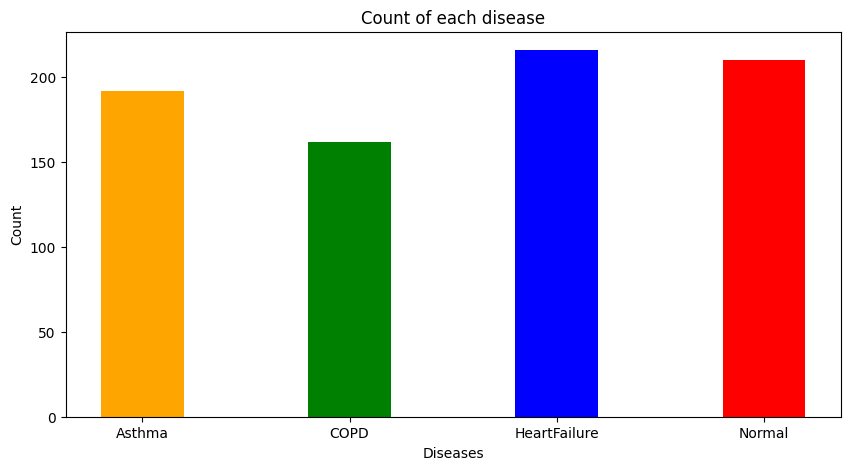

{'Asthma': 192, 'COPD': 162, 'HeartFailure': 216, 'Normal': 210}


In [71]:
 augmented_data_count(y_mfccs)

In [72]:

y_data_encode = y_mfccs.reshape(y_mfccs.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0]).reshape(1,4) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Asthma',np.array([0,1,0,0]).reshape(1,4) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'HeartFailure',np.array([0,0,1,0]).reshape(1,4) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Normal',np.array([0,0,0,1]).reshape(1,4) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [73]:
x_mfccs.shape,Y_data.shape

((780, 40), (780, 4))

In [75]:
# Splitting data into training ,validation and testing sets
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(x_mfccs,Y_data , test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(594, 40) (137, 40) (49, 40)
(594, 4) (137, 4) (49, 4)


In [77]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [79]:
from tensorflow.keras.models import Sequential, Model
from keras.layers import GRU, Input, LeakyReLU, add, Dense, Dropout
from keras.models import Model

def InstantiateModel(in_):
    '''
    Architecture of the Deep Learning Model.
    Args:
        in_: input tensor shape
    Returns: Tensor model
    '''
    model_2_1 = GRU(32, return_sequences=True, activation=None, go_backwards=True)(in_)
    model_2 = LeakyReLU()(model_2_1)
    model_2 = GRU(128, return_sequences=True, activation=None, go_backwards=True)(model_2)
    model_2 = LeakyReLU()(model_2)

    model_3 = GRU(64, return_sequences=True, activation=None, go_backwards=True)(in_)
    model_3 = LeakyReLU()(model_3)
    model_3 = GRU(128, return_sequences=True, activation=None, go_backwards=True)(model_3)
    model_3 = LeakyReLU()(model_3)

    model_add_1 = add([model_3, model_2])

    model_5 = GRU(128, return_sequences=True, activation=None, go_backwards=True)(model_add_1)
    model_5 = LeakyReLU()(model_5)
    model_5 = GRU(32, return_sequences=True, activation=None, go_backwards=True)(model_5)
    model_5 = LeakyReLU()(model_5)

    model_6 = GRU(64, return_sequences=True, activation=None, go_backwards=True)(model_add_1)
    model_6 = LeakyReLU()(model_6)
    model_6 = GRU(32, return_sequences=True, activation=None, go_backwards=True)(model_6)
    model_6 = LeakyReLU()(model_6)

    model_add_2 = add([model_5, model_6, model_2_1])

    model_7 = Dense(64, activation=None)(model_add_2)
    model_7 = LeakyReLU()(model_7)
    model_7 = Dropout(0.2)(model_7)
    model_7 = Dense(16, activation=None)(model_7)
    model_7 = LeakyReLU()(model_7)

    model_9 = Dense(32, activation=None)(model_add_2)
    model_9 = LeakyReLU()(model_9)
    model_9 = Dropout(0.2)(model_9)
    model_9 = Dense(16, activation=None)(model_9)
    model_9 = LeakyReLU()(model_9)

    model_add_3 = add([model_7, model_9])

    model_10 = Dense(16, activation=None)(model_add_3)
    model_10 = LeakyReLU()(model_10)
    model_10 = Dropout(0.5)(model_10)
    model_10 = Dense(4, activation="softmax")(model_10)

    return model_10

# Assuming you have an input tensor, you can create the model as follows:
input_tensor = Input(shape=(1,40))  # Replace ... with the actual shape of your input
model = Model(inputs=input_tensor, outputs=InstantiateModel(input_tensor))

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 40)]              0         []                            
                                                                                                  
 gru_18 (GRU)                (None, 1, 64)                20352     ['input_3[0][0]']             
                                                                                                  
 gru_16 (GRU)                (None, 1, 32)                7104      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_28 (LeakyReLU)  (None, 1, 64)                0         ['gru_18[0][0]']              
                                                                                            

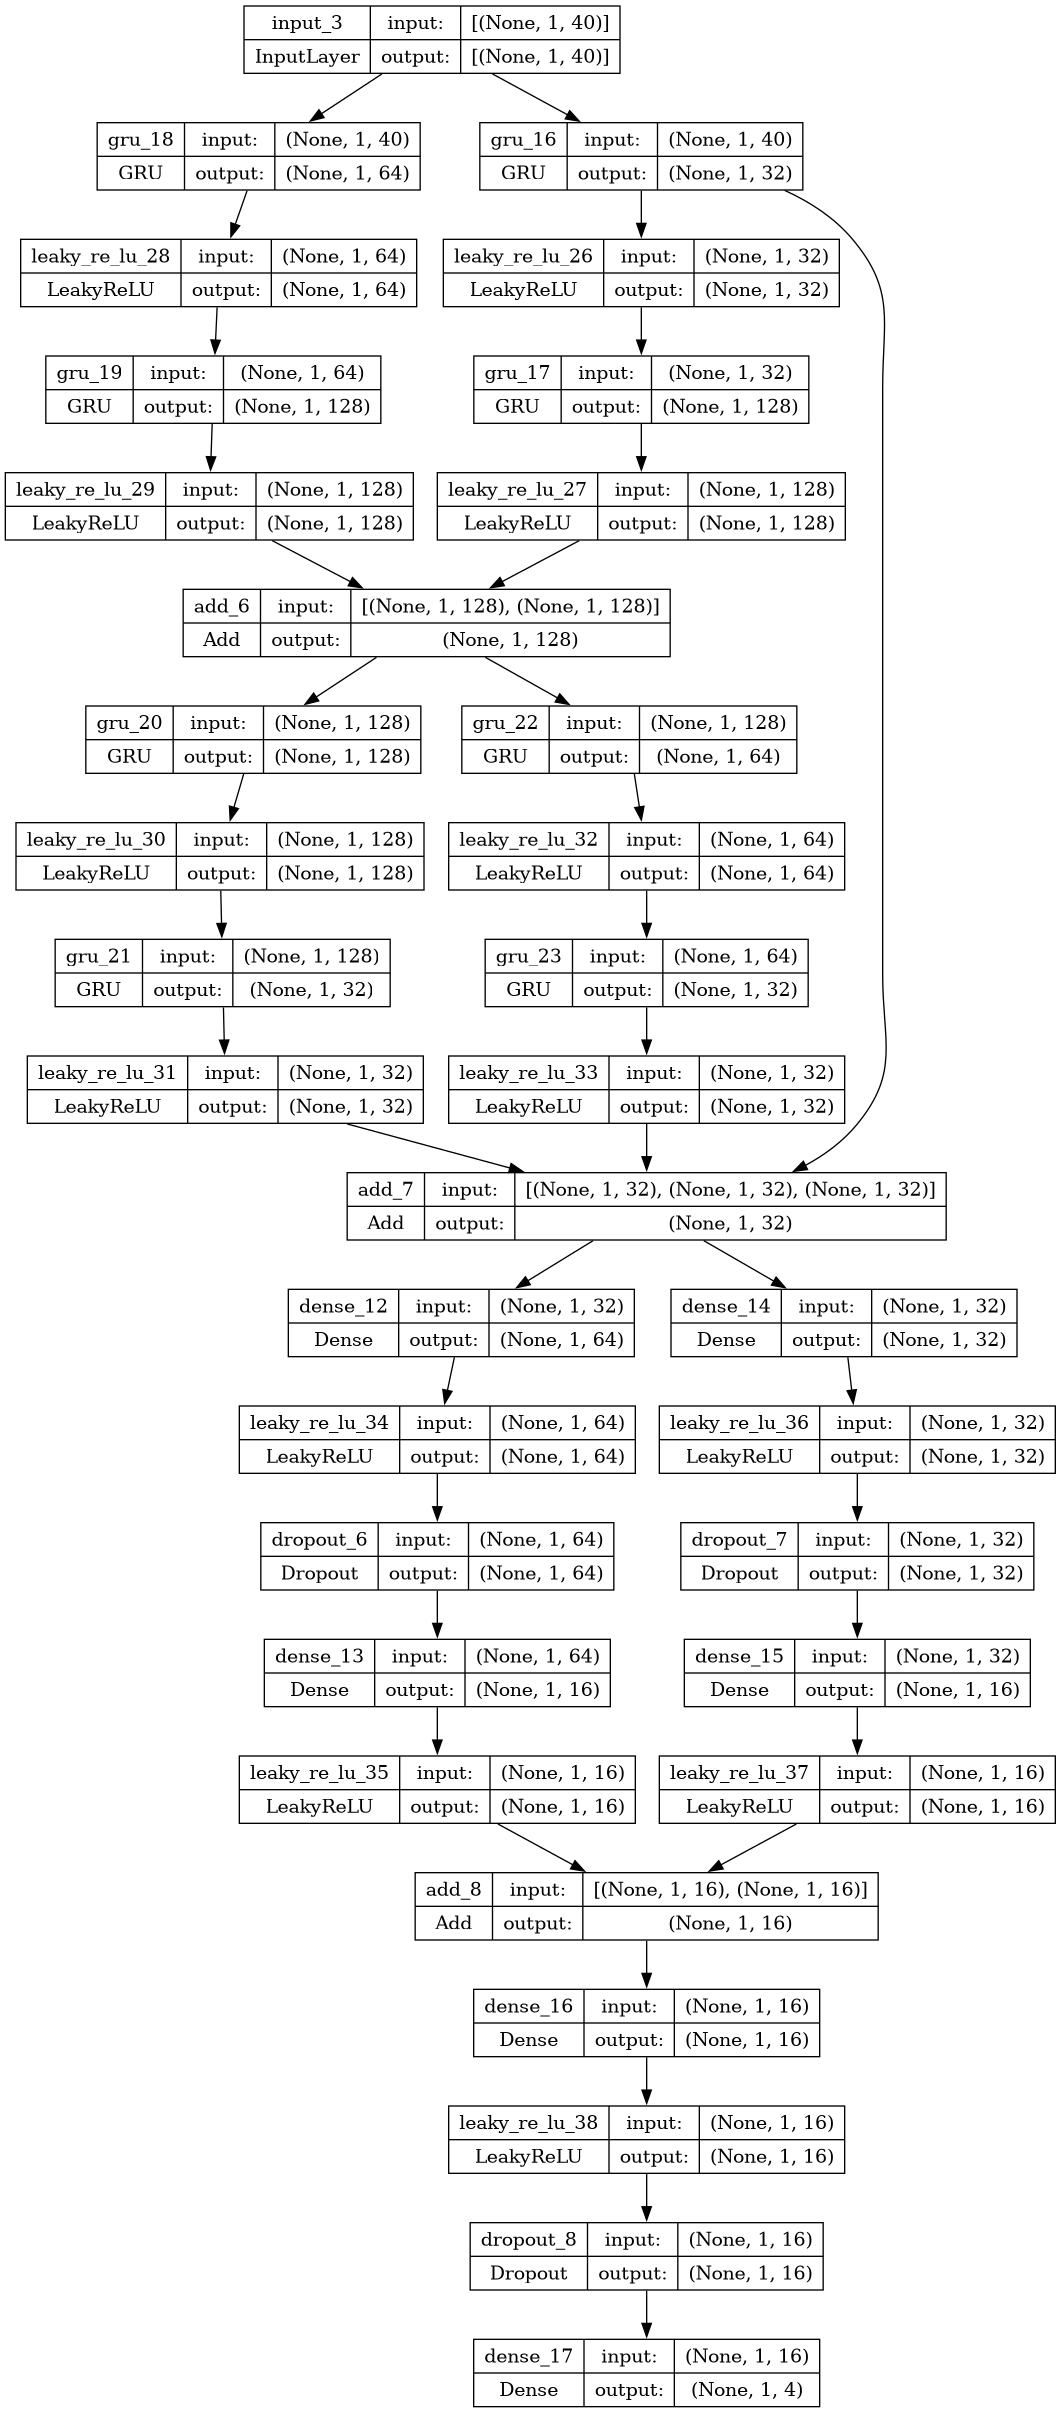

In [80]:
import  tensorflow as tf
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [81]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

cb = tf.keras.callbacks.EarlyStopping(patience=300,monitor='accuracy',mode='max',restore_best_weights=True)

In [82]:
history = model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=1000,validation_data=(x_val_gru, y_val_gru),  callbacks = cb)

Epoch 1/1000
75/75 [==============================] - 16s 29ms/step - loss: 18.0655 - accuracy: 0.2811 - val_loss: 5.0502 - val_accuracy: 0.2555
Epoch 2/1000
75/75 [==============================] - 1s 10ms/step - loss: 7.9009 - accuracy: 0.2508 - val_loss: 1.8781 - val_accuracy: 0.3650
Epoch 3/1000
75/75 [==============================] - 1s 10ms/step - loss: 5.3492 - accuracy: 0.2542 - val_loss: 1.4308 - val_accuracy: 0.3358
Epoch 4/1000
75/75 [==============================] - 1s 10ms/step - loss: 4.1463 - accuracy: 0.2795 - val_loss: 1.6532 - val_accuracy: 0.2920
Epoch 5/1000
75/75 [==============================] - 1s 10ms/step - loss: 3.4489 - accuracy: 0.2559 - val_loss: 1.4319 - val_accuracy: 0.3139
Epoch 6/1000
75/75 [==============================] - 1s 10ms/step - loss: 2.7063 - accuracy: 0.2694 - val_loss: 1.4393 - val_accuracy: 0.3285
Epoch 7/1000
75/75 [==============================] - 1s 9ms/step - loss: 2.5848 - accuracy: 0.2744 - val_loss: 1.3620 - val_accuracy: 0.335

In [100]:
Model_Results = model.evaluate(x_test_gru, y_test_gru)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

2/2 [==============================] - 0s 10ms/step - loss: 0.5669 - accuracy: 0.8571
LOSS:  0.5669
ACCURACY:  0.8571


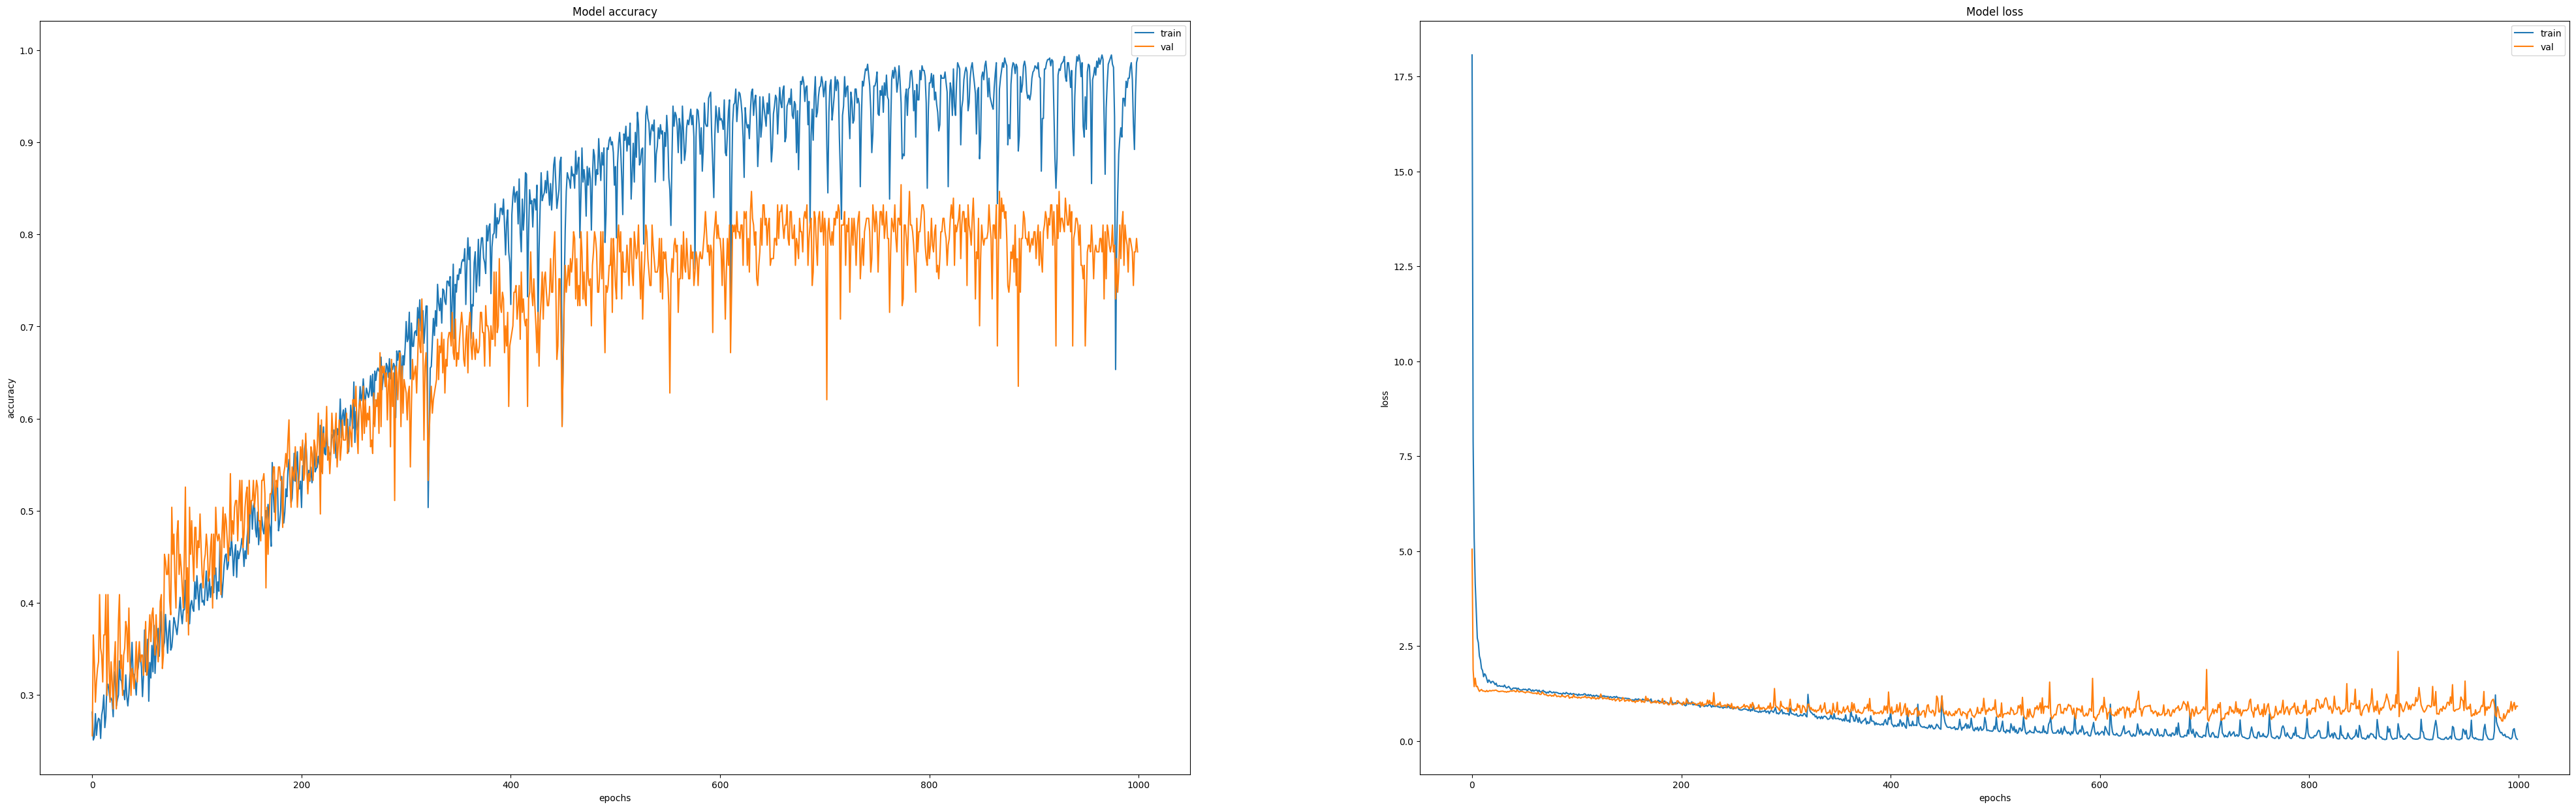

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(50,15))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

2/2 [==============================] - 1s 5ms/step


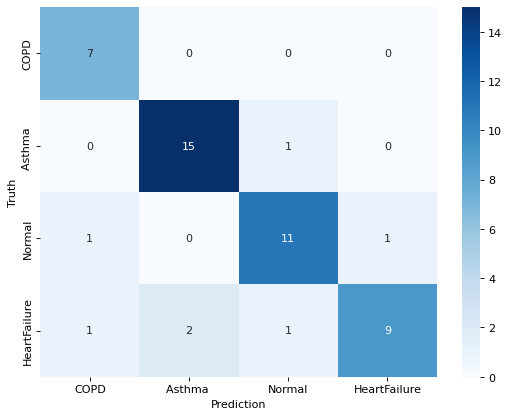

In [84]:
from sklearn.metrics import confusion_matrix, classification_report
classes = ["COPD" ,"Asthma ", "Normal", "HeartFailure"]
preds = model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [85]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

        COPD       0.78      1.00      0.88         7
     Asthma        0.88      0.94      0.91        16
      Normal       0.85      0.85      0.85        13
HeartFailure       0.90      0.69      0.78        13

    accuracy                           0.86        49
   macro avg       0.85      0.87      0.85        49
weighted avg       0.86      0.86      0.85        49



In [87]:
def predict_class(audio_file_path, model, classes, features=40, soundDir=''):
    val = []
    data_x, sampling_rate = librosa.load(audio_file_path + soundDir)
    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
    val.append(mfccs)
    val = np.expand_dims(val, axis=1)
    prediction = classes[np.argmax(model.predict(val))]
    print(prediction)
    print('*************')


In [95]:

dir1 = '/kaggle/input/test-audio/data_test/normal.wav'
predict_class(dir1, model, classes)

dir2 = '/kaggle/input/test-audio/data_test/asthma.wav'
predict_class(dir2, model, classes)



1/1 [==============================] - 0s 37ms/step
Asthma 
*************
1/1 [==============================] - 0s 40ms/step
Asthma 
*************
